In [1]:
%pylab inline
plt.style.use("default")
import os, sys
import scipy
import helpers as h
from glob import glob
from scipy.io import loadmat
from scipy.sparse.linalg import eigsh
from mpl_toolkits import mplot3d
from scipy.stats import skewnorm 
from scipy.stats import skew, kurtosis
import matplotlib.gridspec as Gridspec

plt.rcParams['figure.figsize'] = (15, 10) 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Load functions for computations

In [5]:
def pad_vector(v, desired_length, pad_with = np.nan):
    v_new = np.zeros((desired_length,))
    v_new[:len(v)] = v
    v_new[len(v):] = pad_with
    return v_new


def abib_cdf(r, r_min = -np.inf, **kwargs):
    r_kept = r[r>r_min]
    print(f"Dropped {len(r) - len(r_kept)} values less than {r_min=}")
    x = sorted(r_kept)
    y = arange(1, len(r_kept)+1)/(len(r_kept))
    plot(x,y, **kwargs)
    xlabel("Samples"); ylabel("Cumulative Probability")
    return r_kept

def abib_metric(X):
    n = X.shape[0]
    X2 = X**2
    EX2 = mean(sum(X2, axis=0))
    r = EX2/n
    return r 

# Load directory for data

In [6]:
data_root = "/Users/duuta/ppp/data/stringer/"
data_files = [fname.split("/")[-1] for fname in glob(f"{data_root}natimg2800_M*.mat")]
# data_files

# Load data

In [7]:
data = loadmat(os.path.join(data_root, data_files[1])
               ,simplify_cells = True) 

In [8]:
resp = data['stim']['resp']

# computing power law 

In [9]:
ss_resp = h.test_vars(resp)

In [10]:
alpha_resp, fit_resp = h.get_alpha_fit(ss_resp, np.arange(10, 5e2).astype('int'))

In [20]:
xvalues= mean(resp, axis=0)
yvalues= arange(9039)

In [11]:
t0=scipy.signal.fftconvolve(resp, resp)

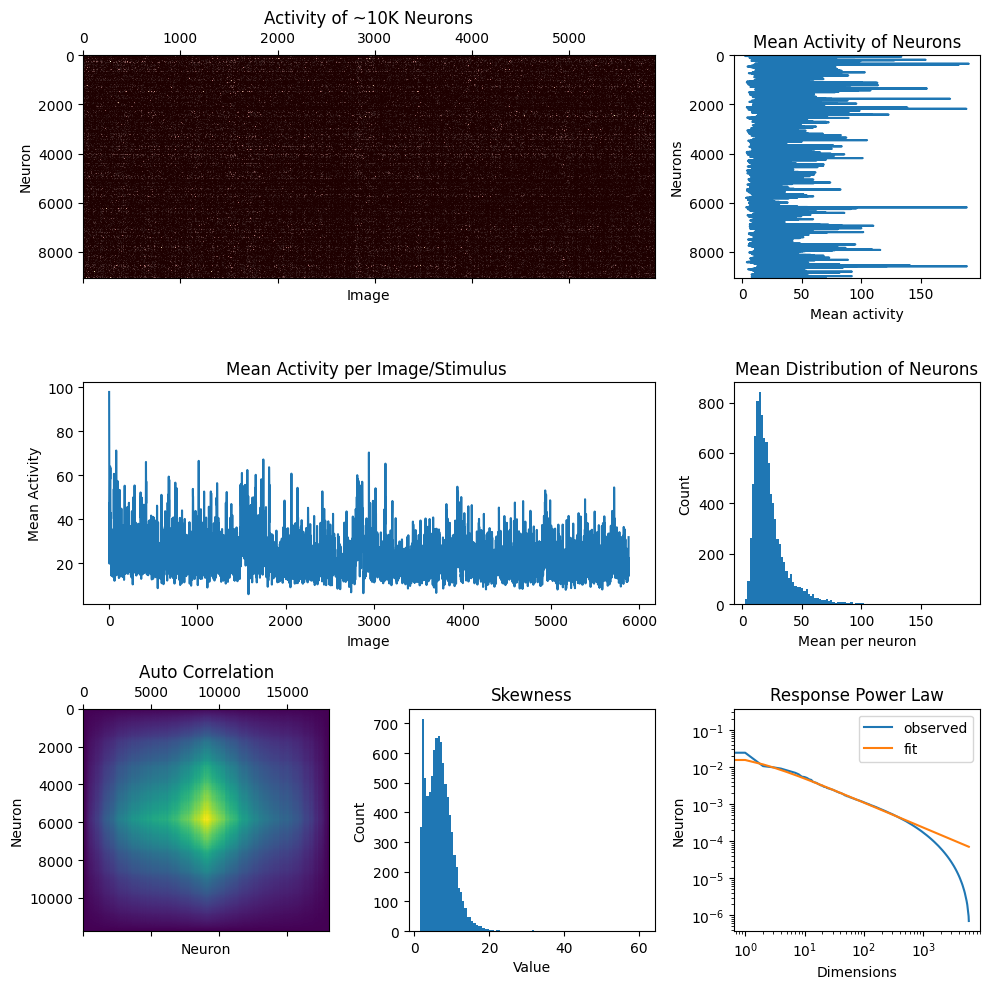

In [24]:
fig0 = plt.figure(constrained_layout= True, figsize=(10, 10))
gs= GridSpec(6, 6, figure=fig0)

# data
ax0_data = fig0.add_subplot(gs[0:2, :4])
matshow(resp.T, cmap=cm.pink, fignum=False, aspect='auto')
title("Activity of ~10K Neurons")
xlabel('Image')
ylabel('Neuron')

ax0_mnr = fig0.add_subplot(gs[0:2, 4:6] , sharey=ax0_data)
plot(xvalues, yvalues)
title('Mean Activity of Neurons') 
xlabel('Mean activity') 
ylabel('Neurons') 

# mean distribution across stimulus
ax0_mir = fig0.add_subplot(gs[2:4, :4])
plot(mean(resp, axis=1))
xlabel("Image")
ylabel("Mean Activity")
title("Mean Activity per Image/Stimulus ")

# Histogram of the mean response across neurons
ax0_mir = fig0.add_subplot(gs[2:4, 4:6])
hist(mean(resp, axis=0), bins=100)
xlabel('Mean per neuron')
ylabel('Count')
title('Mean Distribution of Neurons')

# Corr Neuron vs Neuron 
ax0_mir = fig0.add_subplot(gs[4:6, 0:2])
matshow(t0, fignum=False, aspect='auto')
xlabel('Neuron')
ylabel('Neuron')
title('Auto Correlation')

# Corr image of the mean response across neurons
ax0_mir = fig0.add_subplot(gs[4:6, 2:4])
hist(skew(resp), bins=100)
xlabel('Value')
ylabel('Count')
title('Skewness')

# Power law of response 
ax0_ivl = fig0.add_subplot(gs[4:6, 4:6])
loglog(ss_resp, label='observed')
plot(fit_resp, label='fit')
xlabel('Dimensions')
ylabel('Neuron')
title('Response Power Law')
legend()

tight_layout()

In [ ]:
mlags = 9000
p = 2*mlags + 1
n = resp.shape[0]
reV = empty((n*n, p))
counter = 0
for j in range(n):
    for i in range(n):
        c=xcorr(resp[j, :], resp[i, :], maxlags=mlags)
        reV[counter, :] = c[1]
        counter +=1